In [1]:
import json
import pickle
import os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob

sns.set_style("darkgrid")

In [2]:
#### Settings
### Learning Rate for 2NN = 0.1, no learning rate decay
### Learning Rate for CNN = 0.01, no learning rate decay

In [3]:
os.chdir("/home/bahy/research/icl-prelab-assignment/")

In [4]:
!pwd

/home/bahy/research/icl-prelab-assignment


In [5]:
datas = []
for file_name in glob("logs_q2/*.txt"):
    print(file_name)
    file = open(file_name, "rb")
    for data in file.readlines():
        if len(data) < 10: # Ignoring blank space/not useful information
            continue
        dict_data = eval(data)
        dict_data['setting'] = file_name.split("/")[1].split("-")[0]
        dict_data['model'] = file_name.split("/")[1].split("-")[-1].split(".")[0]
        datas.append(dict_data)
        
datas = pd.DataFrame(datas)

logs_q2/NONIID-B10-C1.0-MNIST-2NN.txt
logs_q2/IID-B600-C0.1-MNIST-2NN.txt
logs_q2/NONIID-B10-C0.0-MNIST-CNN.txt
logs_q2/NONIID-B10-C0.1-MNIST-CNN.txt
logs_q2/IID-B10-C0.1-MNIST-2NN.txt
logs_q2/IID-B600-C0.0-MNIST-2NN.txt
logs_q2/IID-B600-C1.0-MNIST-CNN.txt
logs_q2/NONIID-B10-C0.1-MNIST-2NN.txt
logs_q2/NONIID-B10-C0.0-MNIST-2NN.txt
logs_q2/IID-B600-C0.0-MNIST-CNN.txt
logs_q2/NONIID-B600-C0.1-MNIST-2NN.txt
logs_q2/IID-B10-C1.0-MNIST-CNN.txt
logs_q2/IID-B10-C0.0-MNIST-2NN.txt
logs_q2/NONIID-B600-C0.1-MNIST-CNN.txt
logs_q2/NONIID-B600-C0.0-MNIST-2NN.txt
logs_q2/IID-B10-C0.0-MNIST-CNN.txt
logs_q2/IID-B600-C0.1-MNIST-CNN.txt
logs_q2/NONIID-B600-C0.0-MNIST-CNN.txt
logs_q2/IID-B10-C0.1-MNIST-CNN.txt
logs_q2/IID-B10-C1.0-MNIST-2NN.txt


In [6]:
# Sort the data
ROUNDING_DIGIT = 4

df_metrics = datas.sort_values(by=['model', 'setting', 'B', 'C', 'comm_round']).reset_index(drop=True)
df_metrics['train_acc'] = df_metrics['train_acc'].apply(lambda x: round(x, ROUNDING_DIGIT))
df_metrics['test_acc'] = df_metrics['test_acc'].apply(lambda x: round(x, ROUNDING_DIGIT))
df_metrics['train_loss'] = df_metrics['train_loss'].apply(lambda x: round(x, ROUNDING_DIGIT))
df_metrics['test_loss'] = df_metrics['test_loss'].apply(lambda x: round(x, ROUNDING_DIGIT))
df_metrics.head()

,C,B,comm_round,train_acc,test_acc,train_loss,test_loss,setting,model
0,0.0,10,1,0.7448,0.7448,4.0410,4.0120,IID,2NN
1,0.0,10,2,0.8134,0.8164,2.9616,2.9090,IID,2NN
2,0.0,10,3,0.8047,0.8138,3.0942,2.9425,IID,2NN
3,0.0,10,4,0.8851,0.8931,1.8170,1.6892,IID,2NN
4,0.0,10,5,0.8728,0.8793,2.0206,1.9154,IID,2NN


In [7]:
df_metrics.shape

(20795, 9)

In [13]:
df_metrics.groupby(["model", "setting", "B", "C"]).size()

model  setting  B    C  
2NN    IID      10   0.0     127
                     0.1      53
                     1.0      45
                600  0.0    2449
                     0.1    2526
       NONIID   10   0.0    2764
                     0.1    1138
                     1.0    1176
                600  0.0    2620
                     0.1    2176
CNN    IID      10   0.0      23
                     0.1      13
                     1.0      13
                600  0.0     449
                     0.1     402
                     1.0     426
       NONIID   10   0.0     735
                     0.1     922
                600  0.0    1118
                     0.1    1620
dtype: int64

In [8]:
df_metrics.groupby(["model", "setting", "B", "C"])['test_acc'].max()

model  setting  B    C  
2NN    IID      10   0.0    0.9705
                     0.1    0.9710
                     1.0    0.9701
                600  0.0    0.9700
                     0.1    0.9700
       NONIID   10   0.0    0.9703
                     0.1    0.9707
                     1.0    0.9703
                600  0.0    0.9708
                     0.1    0.9701
CNN    IID      10   0.0    0.9701
                     0.1    0.9712
                     1.0    0.9709
                600  0.0    0.9701
                     0.1    0.9704
                     1.0    0.9700
       NONIID   10   0.0    0.9744
                     0.1    0.9724
                600  0.0    0.9708
                     0.1    0.9702
Name: test_acc, dtype: float64

In [10]:
def make_monotonic(input_df, metric):
    input_df = input_df.reset_index(drop=True)
    
    if "acc" in metric:
        max_val = input_df[metric][0]
        keep = []

        for i in range(len(input_df)):
            current = input_df[metric][i]
            if max_val <= current:
                keep.append(input_df['comm_round'].index[i])
                max_val = current     
    else:
        min_val = input_df[metric][0]
        keep = []

        for i in range(len(input_df)):
            current = input_df[metric][i]
            if min_val >= current:
                keep.append(input_df['comm_round'].index[i])
                min_val = current
    
    return input_df.iloc[keep].reset_index(drop=True)

def fill_the_gap(input_df, round_to_achieve):
    if len(input_df) == round_to_achieve:
        return input_df
    
    initial_comm = input_df.tail(1)['comm_round'].values[0]
    for i in range(round_to_achieve - initial_comm):
        add_df = input_df.tail(1)
        add_df['comm_round'] = add_df['comm_round'] + 1
        input_df = input_df.append(add_df)
    
    return input_df.reset_index(drop=True)

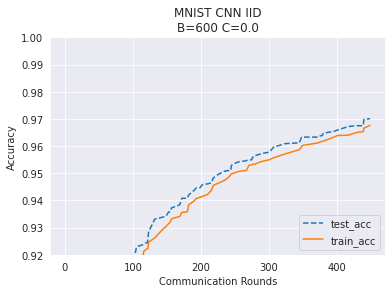

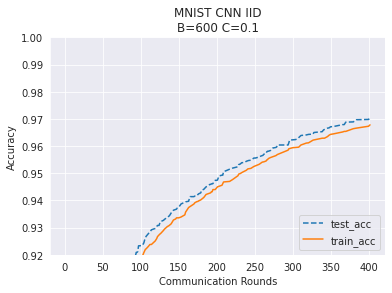

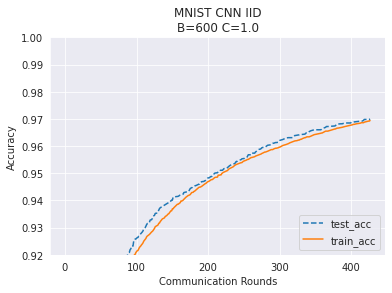

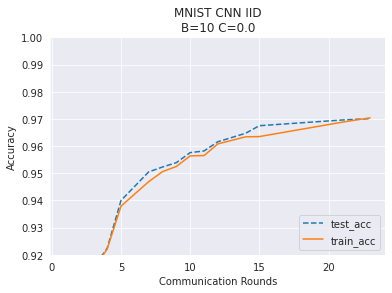

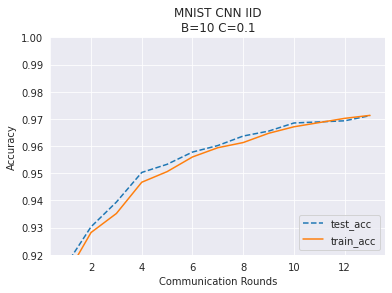

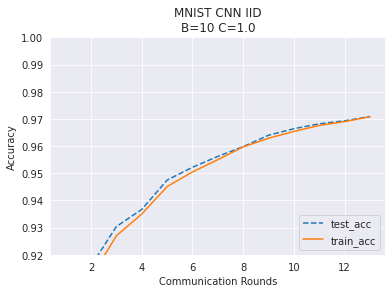

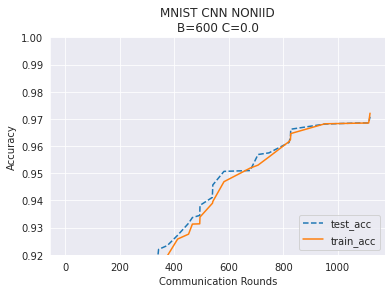

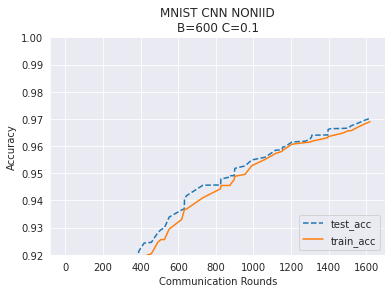

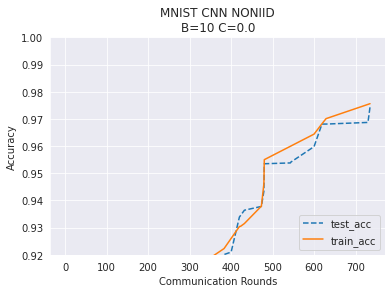

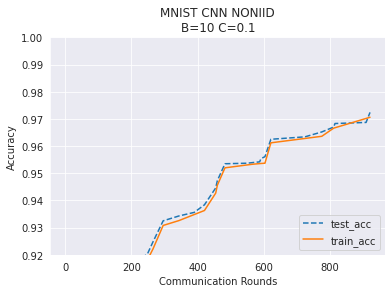

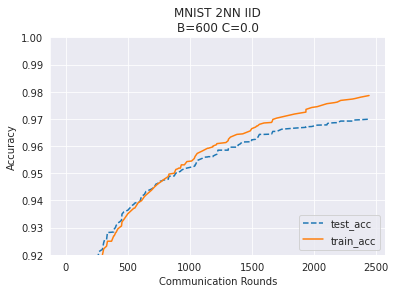

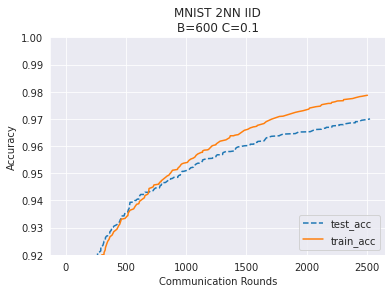

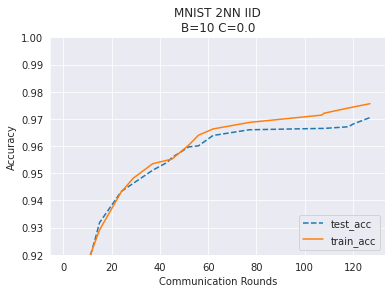

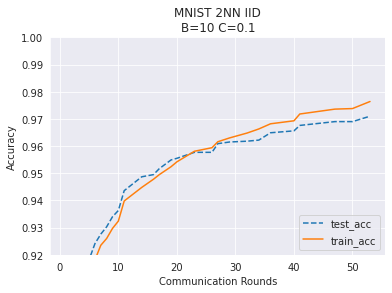

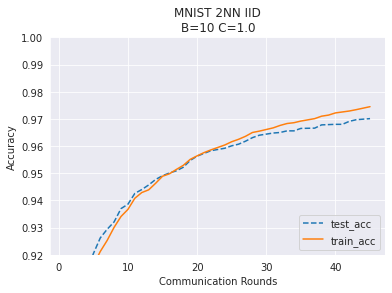

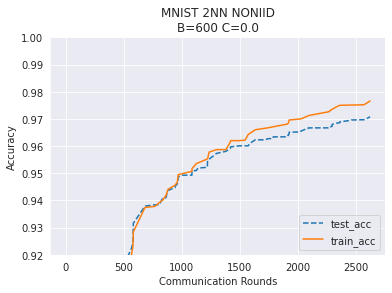

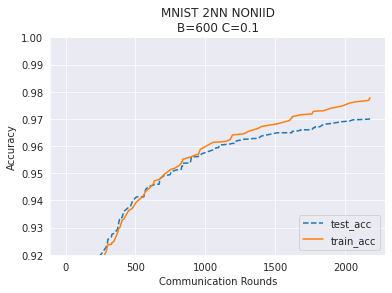

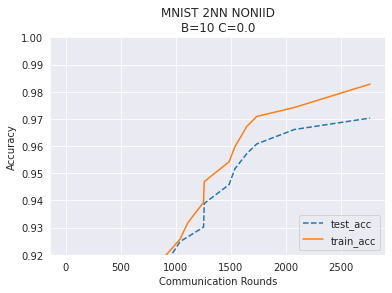

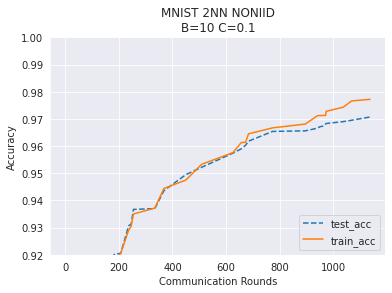

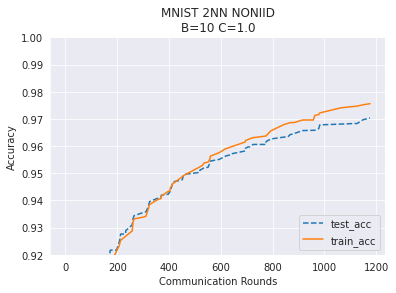

In [14]:
# Plot all accuracy and losses
MODELS = ["CNN", "2NN"]
SETTINGS = ["IID", "NONIID"]
BATCHES = [600, 10]
C_FRACTIONS = [0.0, 0.1, 1.0]

for model in MODELS:
    for setting in SETTINGS:
        for b in BATCHES:
            for c in C_FRACTIONS:
                sample_df = df_metrics[(df_metrics['B']==b) & (df_metrics['C']==c)\
                                       & (df_metrics['setting']==setting) & (df_metrics['model']==model)]\
                                        .reset_index(drop=True)
                if len(sample_df) == 0:
                    continue
                styles = ['dashed', 'solid']
                metrics = ["test_acc", "train_acc"]
                for i in range(2):
                    style, metric = styles[i], metrics[i]
                    max_len = len(sample_df)
                    sample_df = make_monotonic(sample_df, metric)
                    sample_df = fill_the_gap(sample_df, max_len)

                    sns.lineplot(data=sample_df, x='comm_round', y=metric, label=metric, linestyle=style)

                plt.ylim(0.92, 1)
                plt.title("MNIST %s %s\nB=%s C=%s" % (model, setting, b, c))
                plt.ylabel("Accuracy")
                plt.xlabel("Communication Rounds")
                plt.legend(loc='lower right')
                plt.show()